In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import DBSCAN
%matplotlib widget

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=5
diffusion="0.05percent"
# diffusion="nodiff"
# file_id = "1"
file_id = "2638"

if (pressure == 1):
    det_size = 6.182*1e3
elif (pressure == 5):
    det_size = 3.615*1e3
elif (pressure == 10):
    det_size = 2.870*1e3
elif (pressure == 15):
    det_size = 2.507*1e3
elif (pressure == 25):
    det_size = 2.114*1e3


# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")


hits_true = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_Efilt_smear_{file_id}.h5", "MC/hits")

if (diffusion == "nodiff"):
    hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_Efilt_smear_{file_id}.h5", "MC/hits")
else:
    hits      = pd.read_hdf(f"../data/ATPC_0nubb/ATPC_0nubb_{pressure}bar_Efilt_{diffusion}_smear_{file_id}.h5", "MC/hits")


# hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_1bar_nexus_2954.h5", "MC/hits")
# hits = pd.read_hdf("../data/ATPC_Tl/ATPC_Tl_1bar_smear_2954.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

eid=event_list[14]
eid = 321979

data = hits[hits.event_id ==eid]
# data = CutandRedistibuteEnergy(data, 0.0004)

data_true = hits_true[hits_true.event_id == eid]
# data_true["z"] = data_true["z"]-det_size/2.0

# print(hits.event_id.unique())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,event_id,x,y,z,energy
0,232232,-429.632202,228.591171,3149.199219,0.000025
1,232232,-521.622375,269.494415,3159.508545,0.000025
2,232232,-448.315521,217.125549,3164.473145,0.000025
3,232232,-465.809113,269.185883,3166.037598,0.001885
4,232232,-505.881073,218.432602,3166.139893,0.000248
...,...,...,...,...,...
20556,232302,-486.184601,-628.377991,1214.288818,0.035960
20557,232302,-426.451630,-631.493835,1214.702759,0.000025
20558,232302,-468.921295,-628.191345,1215.277466,0.039283
20559,232302,-469.834381,-642.075500,1215.421875,0.008010


In [10]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist = InitializeParams(pressure, diffusion)

print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Hit grouping factor is: ",     group_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)

group_sf = 1

mean_sigma = round(group_sf*Diff_smear*np.sqrt(0.1*data.z.mean()))
print("mean_sigma:", mean_sigma)

Diffussion smear is:  0.314 mm/sqrt(cm)
Energy threshold is:  0.4 keV
diffision scale factor is:  4
Radius scale factor is:  7
Hit grouping factor is:  3
Tortuosity distance scale is: 105.0
mean_sigma: 3


In [11]:
reco_DE_event = data.copy()

print(len(reco_DE_event))

reco_DE_event = CutandRedistibuteEnergy(reco_DE_event, energy_threshold)

df_merged = GroupHits(reco_DE_event, mean_sigma)

# If we have too many groups then bump up the voxel size since the track was broken too much
if (len(df_merged.group_id.unique()) > 10):
    print("Running grouping again new mean sigma is:", mean_sigma*15)
    df_merged = GroupHits(reco_DE_event, mean_sigma*15)

1576
Running grouping again new mean sigma is: 45


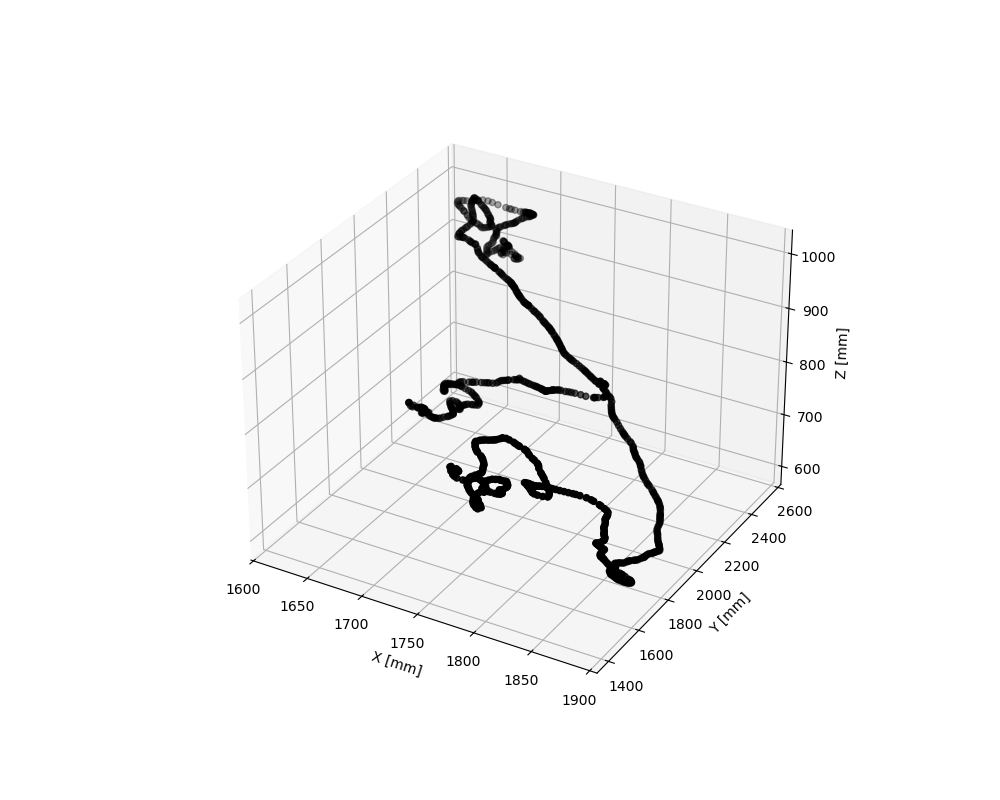

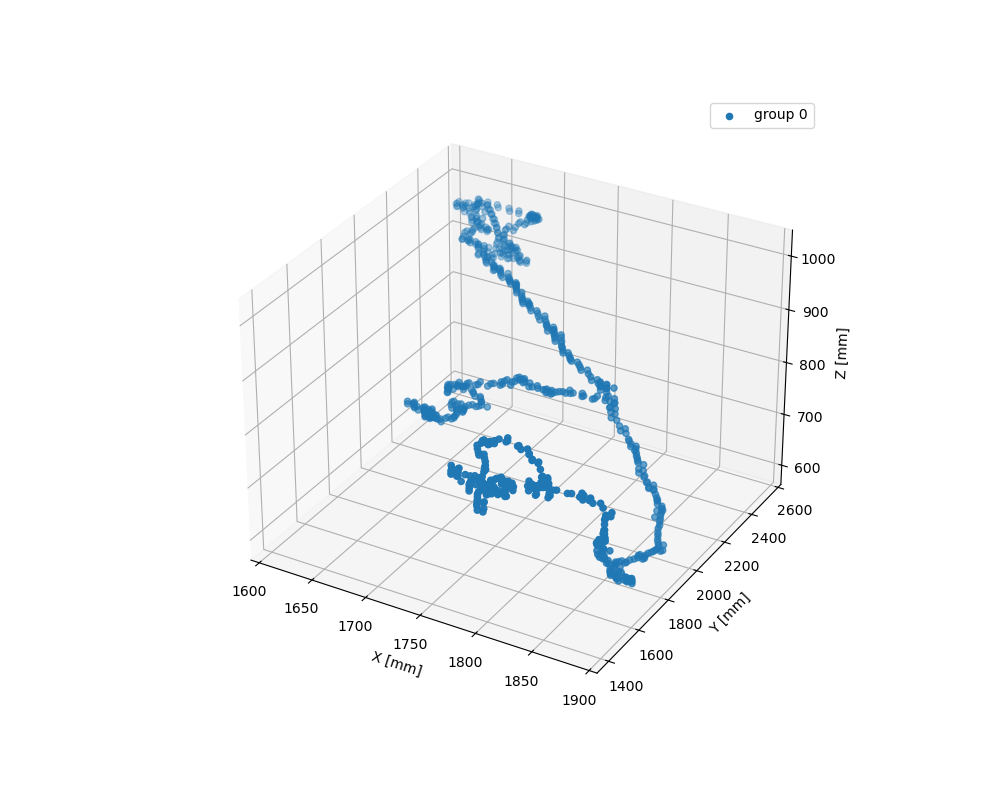

In [12]:

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(data_true['x'], data_true['y'], data_true['z'],c="k")
# ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

ax1.set_xlabel("X [mm]")
ax1.set_ylabel("Y [mm]")
ax1.set_zlabel("Z [mm]")


fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
for gid in sorted(df_merged["group_id"].unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    ax1.scatter(temp_df['x'], temp_df['y'], temp_df['z'],label = f"group {gid}")
    # ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

    ax1.set_xlabel("X [mm]")
    ax1.set_ylabel("Y [mm]")
    ax1.set_zlabel("Z [mm]")
    ax1.legend()
# plt.savefig(f"../../../Projects/Atmospheric TPC/Technical Note/Images/GroupedHits.pdf")

In [2]:
for eid in hits.event_id.unique():
    data = hits[hits.event_id ==eid]

    Diff_smear, energy_threshold, diff_scale_factor, radius_sf, group_sf, Tortuosity_dist = InitializeParams(pressure, diffusion)

    # group_sf = 30
    # energy_threshold=0.0004

    reco_DE_event = CutandRedistibuteEnergy(data, energy_threshold)

    mean_sigma = group_sf*Diff_smear*np.sqrt(0.1*reco_DE_event.z.mean())
    # print(group_sf, Diff_smear, mean_sigma)

    df_merged = GroupHits(reco_DE_event, mean_sigma)

    # # If we have too many groups then bump up the voxel size since the track was broken too much
    # if (len(df_merged.group_id.unique()) > 7):
    #     print("Running grouping again new mean sigma is:", mean_sigma*15)
    #     df_merged = GroupHits(reco_DE_event, mean_sigma*15)

    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(111, projection='3d')
    for gid in sorted(df_merged["group_id"].unique()):
        temp_df = df_merged[df_merged.group_id == gid]
        ax1.scatter(temp_df['x'], temp_df['y'], temp_df['z'],label = f"group {gid}")
        # ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

        ax1.set_xlabel("X [mm]")
        ax1.set_ylabel("Y [mm]")
        ax1.set_zlabel("Z [mm]")
        ax1.legend()

    plt.savefig(f"plots/grouping/{pressure}bar/{diffusion}/{eid}.pdf")
    plt.close()

Running grouping again new mean sigma is: 109.59659130893664
Running grouping again new mean sigma is: 187.1777650979686
Running grouping again new mean sigma is: 203.8573042009391
Running grouping again new mean sigma is: 186.56301306265823
Running grouping again new mean sigma is: 134.0380753468961
Running grouping again new mean sigma is: 127.55463665916638
